<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week6/RNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN Model PyTorch : DeteksiSarkasme.json🍟**

## Instalasi dan Import Library

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import json

In [2]:
# GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load dataset
with open('/content/Cleaned_DeteksiSarkasme.json', 'r') as f:
    data = json.load(f)

In [4]:
# Convert the loaded data to a DataFrame
df = pd.DataFrame(data)


## PreProcessing

In [5]:
# Check if the DataFrame has been loaded correctly
print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
# Make sure the 'is_sarcastic' column is numeric
df['is_sarcastic'] = df['is_sarcastic'].astype(int)


In [7]:
# Preprocessing data
X = df['headline'].values
y = df['is_sarcastic'].values

In [8]:
# Convert text data into features using CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_vec = vectorizer.fit_transform(X).toarray()


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)


In [10]:
# Reshape data to fit RNN (LSTM) requirements
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add sequence dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)    # Add sequence dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)


## Build Model

In [11]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last hidden state
        out = self.fc(out)
        return self.softmax(out)

## Hyperparameter Tuning

In [12]:
# Hyperparameter tuning using GridSearch
param_grid = {
    'learning_rate': [0.0005, 0.01],
    'hidden_size': [64, 128],
    'num_layers': [1, 2]
}

In [13]:
# Custom function to train and evaluate the model
def train_and_evaluate(lr, hidden_size, num_layers):
    model = RNN(input_size=5000, hidden_size=hidden_size, output_size=2, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    epochs = 30
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = 100 * (predicted == y_test_tensor).sum() / len(y_test_tensor)
        return accuracy.item()


In [14]:
# Perform Grid Search for hyperparameter tuning
best_accuracy = 0
best_params = None

In [15]:
from sklearn.model_selection import ParameterGrid  # Pastikan ini diimpor

# Iterate over the grid search combinations
for params in ParameterGrid(param_grid):
    lr = params['learning_rate']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']

    print(f"Training model with lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}")
    accuracy = train_and_evaluate(lr, hidden_size, num_layers)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (lr, hidden_size, num_layers)


Training model with lr=0.0005, hidden_size=64, num_layers=1
Training model with lr=0.0005, hidden_size=64, num_layers=2
Training model with lr=0.01, hidden_size=64, num_layers=1
Training model with lr=0.01, hidden_size=64, num_layers=2
Training model with lr=0.0005, hidden_size=128, num_layers=1
Training model with lr=0.0005, hidden_size=128, num_layers=2
Training model with lr=0.01, hidden_size=128, num_layers=1
Training model with lr=0.01, hidden_size=128, num_layers=2


In [16]:
print(f"Best Hyperparameters: {best_params} with accuracy: {best_accuracy}%")


Best Hyperparameters: (0.01, 64, 1) with accuracy: 77.19955444335938%


## Train Model

In [17]:
# Train the best model with the best hyperparameters
best_lr, best_hidden_size, best_num_layers = best_params
best_model = RNN(input_size=5000, hidden_size=best_hidden_size, output_size=2, num_layers=best_num_layers).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()


In [18]:
# Train the best model
epochs = 30
for epoch in range(epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

## Evaluate

Accuracy on test set: 77.20%


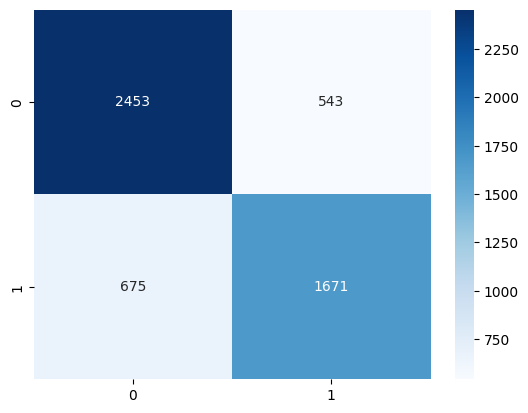

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2996
           1       0.75      0.71      0.73      2346

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



In [19]:
# Evaluate the best model
best_model.eval()
with torch.no_grad():
    outputs = best_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

    # Accuracy
    accuracy = 100 * (predicted == y_test_tensor).sum() / len(y_test_tensor)
    print(f'Accuracy on test set: {accuracy.item():.2f}%')

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.show()

    print(classification_report(y_test_tensor.cpu(), predicted.cpu()))